# 🎬 Analyse Exploratoire des Films : Genre, Durée, Popularité


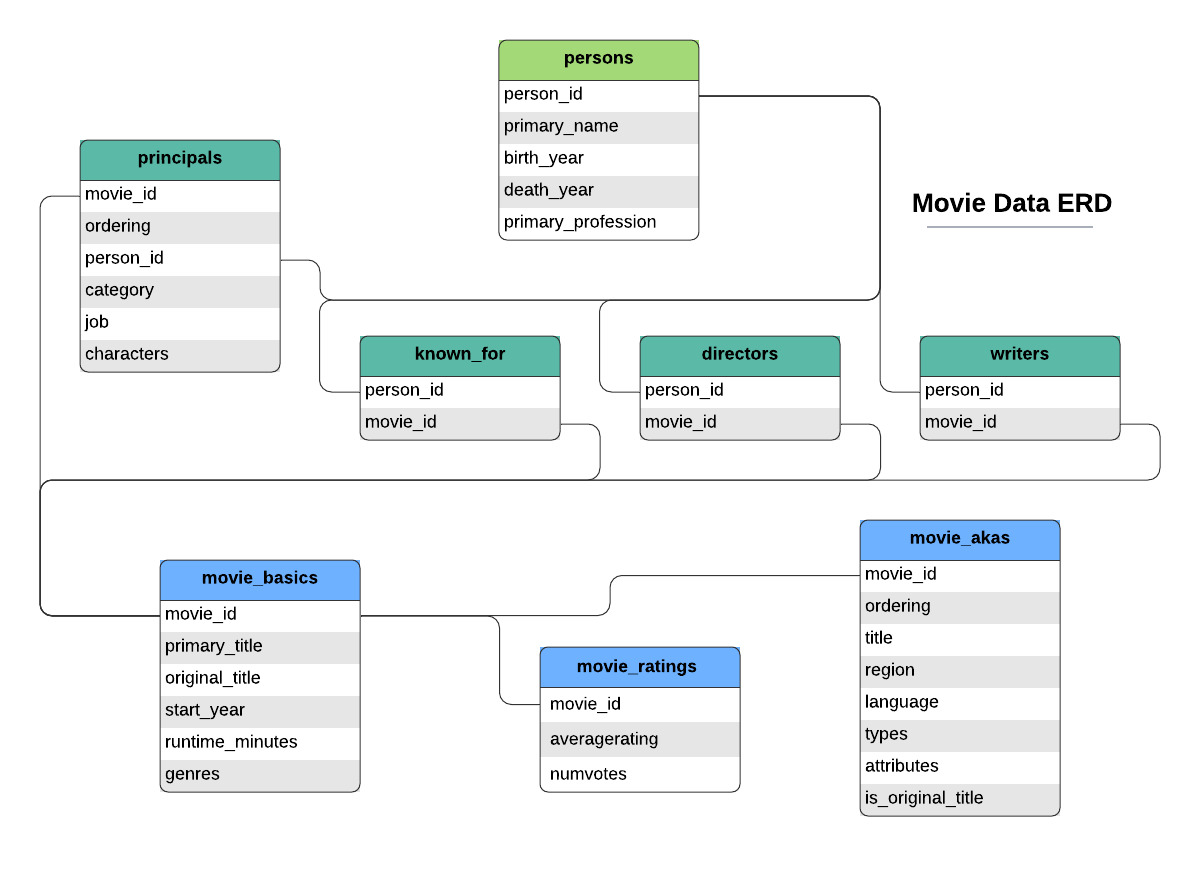

In [2]:
from IPython.display import Image, display

display(Image(filename="../Images/IMDB_ERD.jpeg", width=800))


In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration des graphiques
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Connexion à la base
conn = sqlite3.connect("im.db")


**Chargement des données**

In [9]:
# Charger les tables principales
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)
directors = pd.read_sql("SELECT * FROM directors", conn)
persons = pd.read_sql("SELECT * FROM persons", conn)

# Vérification des tables disponibles
df = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables dans la base :")
print(df)


Tables dans la base :
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


**Fusion des données**

In [10]:
# Fusionner movie_basics et movie_ratings
movies = pd.merge(movie_basics, movie_ratings, on="movie_id", how="left")


**Filtrage des données**

In [11]:
# Garder les films récents avec suffisamment de votes
filtered_movies = movies[(movies['start_year'] >= 2000) & (movies['numvotes'] > 500)].copy()
filtered_movies.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
15,tt0176694,The Tragedy of Man,Az ember tragédiája,2011,160.0,"Animation,Drama,History",7.8,584.0
20,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248.0
32,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053.0
38,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378.0


**Top 10 des films les mieux notés**

In [12]:
top10_movies = filtered_movies.sort_values(by='averagerating', ascending=False).head(10)
print(top10_movies[['primary_title', 'averagerating']])


                                            primary_title  averagerating
136655                                          Eghantham            9.7
118887                  Once Upon a Time ... in Hollywood            9.7
72358                                      I Want to Live            9.6
144567                          Yeh Suhaagraat Impossible            9.6
103419                                Ekvtime: Man of God            9.6
142169                                Ananthu V/S Nusrath            9.6
101973                                      Aloko Udapadi            9.5
133221                                              Mosul            9.5
115351  Hare Krishna! The Mantra, the Movement and the...            9.5
100206                            The Children of Genghis            9.4


**Traitement des genres**

In [13]:
# Nettoyer les genres
filtered_movies['genres'] = filtered_movies['genres'].fillna('')

# Transformer en liste
filtered_movies['genres_list'] = filtered_movies['genres'].apply(lambda x: [g.strip() for g in x.split(",") if g.strip() != ""])

# Exploser pour avoir un genre par ligne
movies_exploded = filtered_movies.explode('genres_list')

# Calcul de la moyenne des notes par genre
genre_avg = movies_exploded.groupby('genres_list')['averagerating'].mean().sort_values(ascending=False)
print(genre_avg)


genres_list
News           7.530556
Documentary    7.196806
Biography      6.937696
History        6.787313
Sport          6.786643
Music          6.722306
Animation      6.559959
Musical        6.463889
War            6.460759
Drama          6.394912
Family         6.259333
Romance        6.238980
Crime          6.177470
Adventure      6.032336
Comedy         5.980927
Mystery        5.912798
Action         5.852269
Western        5.850000
Fantasy        5.830622
Thriller       5.727822
Game-Show      5.600000
Sci-Fi         5.467765
Horror         5.062614
Name: averagerating, dtype: float64


**Moyenne des notes par réalisateur**

In [14]:
directors_data = pd.merge(directors, persons, on='person_id', how='left')
movies_dir = pd.merge(directors_data, movie_ratings, on='movie_id', how='left')

avg_rating_dir = movies_dir.groupby('primary_name')['averagerating'].mean().sort_values(ascending=False)
print(avg_rating_dir.head(10))


primary_name
Chad Carpenter            10.0
Lindsay Thompson          10.0
Masahiro Hayakawa         10.0
Emre Oran                 10.0
Ivana Diniz               10.0
Stephen Peek              10.0
Loreto Di Cesare          10.0
Michiel Brongers          10.0
Tristan David Luciotti    10.0
Raphael Sbarge             9.9
Name: averagerating, dtype: float64


**Croiser movie_basics avec movie_ratings pour voir les films les mieux notés**

In [15]:
#Croiser movie_basics avec movie_ratings pour voir les films les mieux notés
query = """
SELECT b.primary_title, b.start_year, b.genres, r.averagerating, r.numvotes
FROM movie_basics b
JOIN movie_ratings r ON b.movie_id = r.movie_id
WHERE r.numvotes > 10000
ORDER BY r.averagerating DESC
LIMIT 10;
"""
top_movies = pd.read_sql(query, conn)
top_movies


,primary_title,start_year,genres,averagerating,numvotes
0,The Mountain II,2016,"Action,Drama,War",9.3,100568
1,Aynabaji,2016,"Crime,Mystery,Thriller",9.3,18470
2,Wheels,2014,Drama,9.3,17308
3,CM101MMXI Fundamentals,2013,"Comedy,Documentary",9.2,41560
4,O.J.: Made in America,2016,"Biography,Crime,Documentary",8.9,14946
5,Drishyam,2013,"Crime,Drama,Thriller",8.8,24326
6,Ratsasan,2018,"Action,Crime,Thriller",8.8,10518
7,96,2018,"Drama,Romance",8.8,10903
8,Avengers: Endgame,2019,"Action,Adventure,Sci-Fi",8.8,441135
9,Inception,2010,"Action,Adventure,Sci-Fi",8.8,1841066


**Convertir la durée en numérique**

In [16]:
# Convertir la durée en numérique
movies['runtime_minutes'] = pd.to_numeric(movies['runtime_minutes'], errors='coerce')

# Remplacer les NaN dans averagerating par la moyenne
movies['averagerating'] = movies['averagerating'].fillna(movies['averagerating'].mean())

# Remplacer les NaN dans numvotes par 0
movies['numvotes'] = movies['numvotes'].fillna(0)

# Vérification
movies[['runtime_minutes', 'averagerating', 'numvotes']].describe()


,runtime_minutes,averagerating,numvotes
count,114405.000000,146144.000000,1.461440e+05
mean,86.187247,6.332729,1.780734e+03
std,166.360590,1.048544,2.160759e+04
min,1.000000,1.000000,0.000000e+00
25%,70.000000,6.332729,0.000000e+00
50%,87.000000,6.332729,5.000000e+00
75%,99.000000,6.500000,5.100000e+01
max,51420.000000,10.000000,1.841066e+06


**Initialiser une liste des genres uniques**

In [17]:
# Initialiser une liste des genres uniques
genre_list = set()
movies['genres'] = movies['genres'].fillna('')

# Extraire les genres uniques
for g in movies['genres']:
    for genre in g.split(","):
        if genre.strip() != "":
            genre_list.add(genre.strip())

# Créer des colonnes binaires pour chaque genre
for genre in genre_list:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split(",")))

# Vérification rapide
movies[list(genre_list)].head(10)


,Drama,Adventure,Family,Documentary,Biography,News,Fantasy,Sci-Fi,Comedy,Mystery,...,Thriller,Reality-TV,Romance,Short,Crime,Musical,Animation,War,Talk-Show,Sport
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Charger les tables nécessaires**

In [18]:
# Charger les tables nécessaires
principals = pd.read_sql("SELECT * FROM principals", conn)
persons = pd.read_sql("SELECT * FROM persons", conn)

# Fusionner pour obtenir les noms des intervenants
crew = pd.merge(principals, persons, on="person_id", how="left")

# Filtrer pour les réalisateurs
directors = crew[crew['category'] == 'director']
directors[['movie_id', 'primary_name']].head()


,movie_id,primary_name
1,tt0111414,Frank Howson
8,tt0323808,Robin Hardy
18,tt0417610,Alejandro Chomski
28,tt0469152,Alyssa R. Bennett
35,tt0473032,J. Neil Schulman


In [19]:
# Statistiques sur les notes et durées
movies[['averagerating', 'runtime_minutes', 'numvotes']].describe()


,averagerating,runtime_minutes,numvotes
count,146144.000000,114405.000000,1.461440e+05
mean,6.332729,86.187247,1.780734e+03
std,1.048544,166.360590,2.160759e+04
min,1.000000,1.000000,0.000000e+00
25%,6.332729,70.000000,0.000000e+00
50%,6.332729,87.000000,5.000000e+00
75%,6.500000,99.000000,5.100000e+01
max,10.000000,51420.000000,1.841066e+06


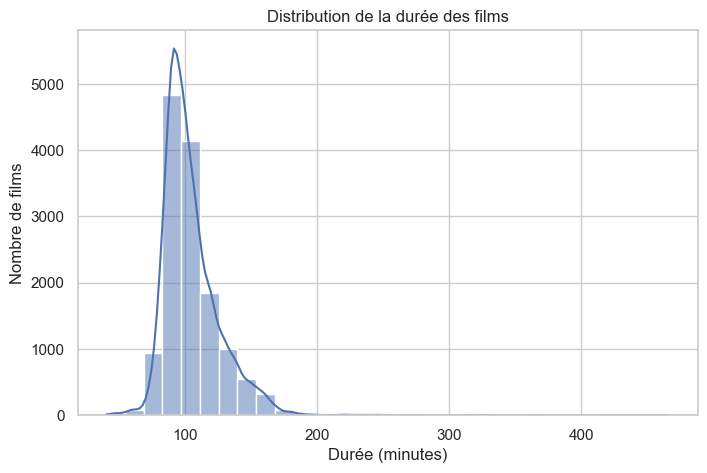

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(filtered_movies['runtime_minutes'], bins=30, kde=True)
plt.title("Distribution de la durée des films")
plt.xlabel("Durée (minutes)")
plt.ylabel("Nombre de films")
plt.show()


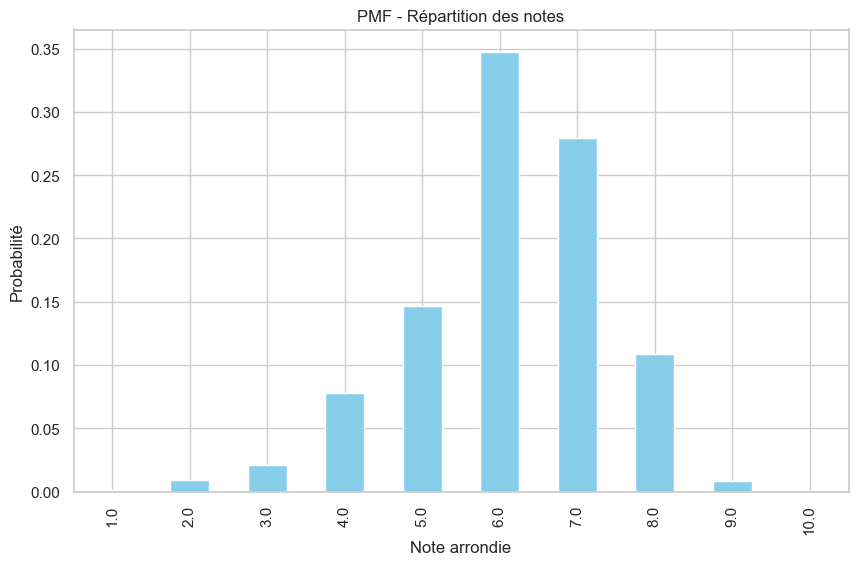

In [21]:
filtered_movies['rounded_rating'] = filtered_movies['averagerating'].round()
pmf = filtered_movies['rounded_rating'].value_counts(normalize=True).sort_index()
pmf.plot(kind='bar', color='skyblue')
plt.title("PMF - Répartition des notes")
plt.xlabel("Note arrondie")
plt.ylabel("Probabilité")
plt.show()


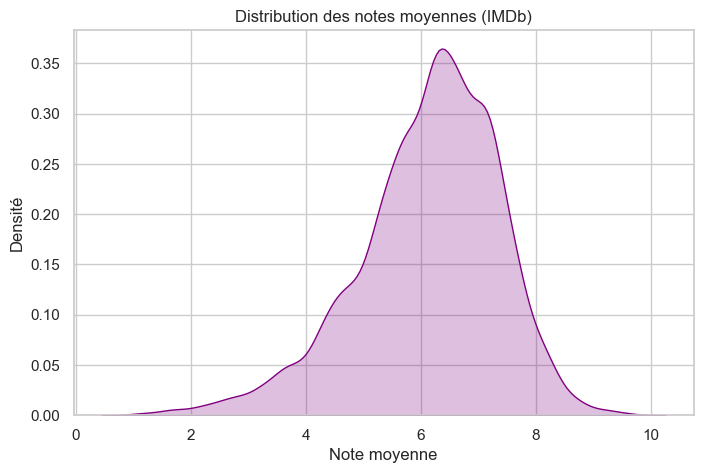

In [22]:
plt.figure(figsize=(8,5))
sns.kdeplot(filtered_movies['averagerating'], fill=True, color='purple')
plt.title("Distribution des notes moyennes (IMDb)")
plt.xlabel("Note moyenne")
plt.ylabel("Densité")
plt.show()

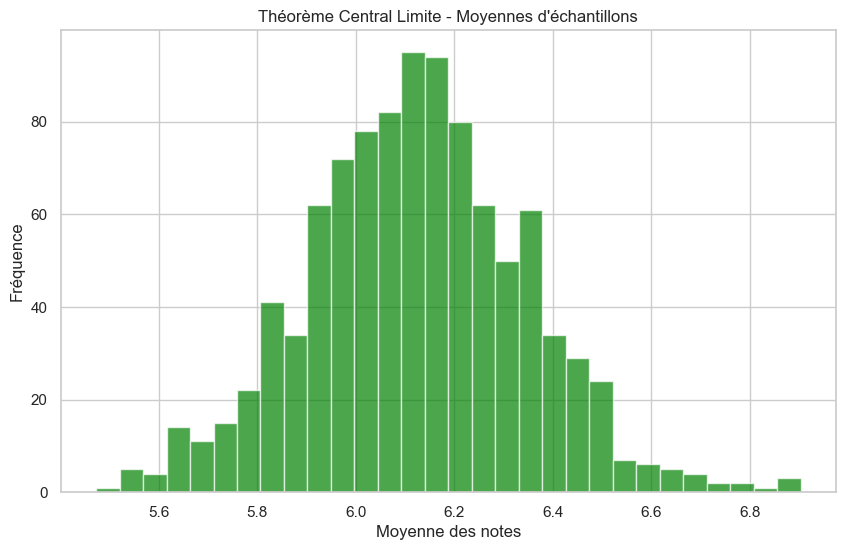

In [23]:
means = []
for i in range(1000):
    sample = filtered_movies['averagerating'].sample(30, replace=True)
    means.append(sample.mean())

plt.hist(means, bins=30, color='green', alpha=0.7)
plt.title("Théorème Central Limite - Moyennes d'échantillons")
plt.xlabel("Moyenne des notes")
plt.ylabel("Fréquence")
plt.show()


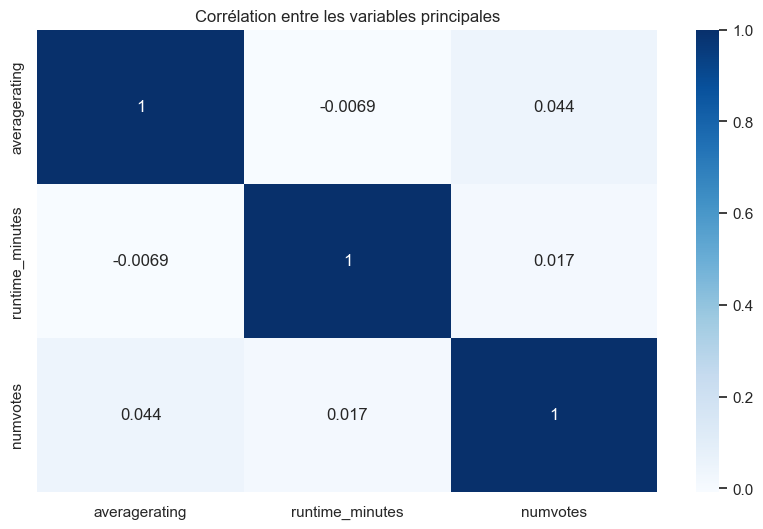

In [24]:
corr = movies[['averagerating', 'runtime_minutes', 'numvotes']].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Corrélation entre les variables principales")
plt.show()


In [25]:
for genre in ['Action', 'Comedy', 'Drama']:
    filtered_movies[genre] = filtered_movies['genres'].apply(lambda x: int(genre in x.split(",")))


In [26]:
from scipy.stats import f_oneway

action = filtered_movies[filtered_movies['Action'] == 1]['averagerating']
comedy = filtered_movies[filtered_movies['Comedy'] == 1]['averagerating']
drama = filtered_movies[filtered_movies['Drama'] == 1]['averagerating']

f_stat, p_value = f_oneway(action, comedy, drama)
print("F-statistic:", f_stat)
print("p-value:", p_value)


F-statistic: 299.7889108461605
p-value: 3.406947119895249e-128


In [27]:
import statsmodels.api as sm

movies_clean = filtered_movies.dropna(subset=['runtime_minutes'])
X = movies_clean['runtime_minutes']
y = movies_clean['averagerating']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1321.
Date:                Sat, 19 Jul 2025   Prob (F-statistic):          2.63e-276
Time:                        13:13:13   Log-Likelihood:                -21887.
No. Observations:               13827   AIC:                         4.378e+04
Df Residuals:                   13825   BIC:                         4.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.3230      0.051     